In [109]:
import pandas as pd
import s3fs

# ----------------------------
# Config MinIO
# ----------------------------
fs = s3fs.S3FileSystem(
    key="minioadmin",
    secret="minioadmin",
    client_kwargs={'endpoint_url': 'http://localhost:9000'}
)

# Dossier Bronze
bronze_path = "s3://bronze/dvdrental/"

# ----------------------------
# Liste tous les fichiers Parquet dans dvdrental/
# ----------------------------
files = fs.ls(bronze_path)

print("Fichiers détectés dans dvdrental/ :", files)

# ----------------------------
# Lire tous les fichiers dans un dictionnaire
# ----------------------------
tables = {}  # clé = nom table, valeur = DataFrame

for f in files:
    # Extraire le nom de la table depuis le nom du fichier
    table_name = f.split("/")[-1].replace(".parquet", "")
    
    # Lire le fichier Parquet
    tables[table_name] = pd.read_parquet(f, filesystem=fs)
    
    # Affiche un résumé
    df = tables[table_name]
    print(f"\n✅ Table '{table_name}': {df.shape[0]} lignes, {df.shape[1]} colonnes")
    print(df.head(3))  # affiche les 3 premières lignes

print("\n🎉 Toutes les tables Bronze ont été chargées dans le dictionnaire 'tables'")


Fichiers détectés dans dvdrental/ : ['bronze/dvdrental/actor.parquet', 'bronze/dvdrental/address.parquet', 'bronze/dvdrental/category.parquet', 'bronze/dvdrental/city.parquet', 'bronze/dvdrental/country.parquet', 'bronze/dvdrental/customer.parquet', 'bronze/dvdrental/film.parquet', 'bronze/dvdrental/film_actor.parquet', 'bronze/dvdrental/film_category.parquet', 'bronze/dvdrental/inventory.parquet', 'bronze/dvdrental/language.parquet', 'bronze/dvdrental/payment.parquet', 'bronze/dvdrental/rental.parquet', 'bronze/dvdrental/staff.parquet', 'bronze/dvdrental/store.parquet']

✅ Table 'actor': 200 lignes, 6 colonnes
   actor_id first_name last_name             last_update  \
0         1   Penelope   Guiness 2013-05-26 14:47:57.620   
1         2       Nick  Wahlberg 2013-05-26 14:47:57.620   
2         3         Ed     Chase 2013-05-26 14:47:57.620   

        _ingestion_timestamp      _source_system  
0 2026-02-03 12:30:17.097575  postgres.dvdrental  
1 2026-02-03 12:30:17.097575  postgres

In [110]:
dim_inventory = pd.read_parquet("s3://bronze/dvdrental/inventory.parquet", filesystem=fs)
dim_film      = pd.read_parquet("s3://bronze/dvdrental/film.parquet", filesystem=fs)
dim_customer  = pd.read_parquet("s3://bronze/dvdrental/customer.parquet", filesystem=fs)
dim_store     = pd.read_parquet("s3://bronze/dvdrental/store.parquet", filesystem=fs)
dim_category  = pd.read_parquet("s3://bronze/dvdrental/category.parquet", filesystem=fs)
film_category = pd.read_parquet("s3://bronze/dvdrental/film_category.parquet", filesystem=fs)


In [111]:
print("Tables currently in 'tables':")
print(list(tables.keys()))

Tables currently in 'tables':
['actor', 'address', 'category', 'city', 'country', 'customer', 'film', 'film_actor', 'film_category', 'inventory', 'language', 'payment', 'rental', 'staff', 'store']


In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   store_id              2 non-null      int64         
 1   manager_staff_id      2 non-null      int64         
 2   address_id            2 non-null      int64         
 3   last_update           2 non-null      datetime64[ns]
 4   _ingestion_timestamp  2 non-null      datetime64[us]
 5   _source_system        2 non-null      object        
dtypes: datetime64[ns](1), datetime64[us](1), int64(3), object(1)
memory usage: 228.0+ bytes


In [114]:
# FACT SILVER (base)
fact = pd.read_parquet(
    "s3://bronze/dvdrental/rental.parquet",
    filesystem=fs
)

# Vérification immédiate
print(fact.shape)
print(fact.columns)


(16044, 9)
Index(['rental_id', 'rental_date', 'inventory_id', 'customer_id',
       'return_date', 'staff_id', 'last_update', '_ingestion_timestamp',
       '_source_system'],
      dtype='object')


In [115]:
fact = (
    fact
    .merge(
        dim_inventory[['inventory_id', 'film_id', 'store_id']],
        on='inventory_id',
        how='left'
    )
    .merge(
        dim_film[['film_id', 'title', 'rental_rate', 'length']],
        on='film_id',
        how='left'
    )
)


In [116]:
dim_film_cat = (
    film_category
    .merge(dim_category, on='category_id', how='left')
    .merge(dim_film[['film_id', 'title']], on='film_id', how='left')
)


In [117]:
dim_customer_silver = dim_customer[['customer_id', 'first_name', 'last_name', 'email']]


In [118]:
dim_store_silver = dim_store[['store_id', 'address_id']]


In [154]:
fact.columns

Index(['rental_id', 'rental_date', 'inventory_id', 'customer_id',
       'return_date', 'staff_id', 'last_update', '_ingestion_timestamp',
       '_source_system'],
      dtype='object')

In [155]:
fact.describe().T

,count,mean,min,25%,50%,75%,max,std
rental_id,16044.0,8025.371478,1.0,4013.75,8025.5,12037.25,16049.0,4632.777249
rental_date,16044,2005-07-23 08:12:53.217526912,2005-05-24 22:53:30,2005-07-07 00:58:40.500000,2005-07-28 16:04:32.500000,2005-08-17 21:16:23,2006-02-14 15:16:03,NaN
inventory_id,16044.0,2291.842558,1.0,1154.0,2291.0,3433.0,4581.0,1322.210643
customer_id,16044.0,297.143169,1.0,148.0,296.0,446.0,599.0,172.453136
return_date,15861,2005-07-25 23:58:03.138768128,2005-05-25 23:55:21,2005-07-10 15:49:36,2005-08-01 19:45:29,2005-08-20 23:35:55,2005-09-02 02:35:22,NaN
staff_id,16044.0,1.498878,1.0,1.0,1.0,2.0,2.0,0.500014
last_update,16044,2006-02-16 02:31:31.074980992,2006-02-15 21:30:53,2006-02-16 02:30:53,2006-02-16 02:30:53,2006-02-16 02:30:53,2006-02-23 09:12:08,NaN
_ingestion_timestamp,16044,2026-02-03 12:30:38.491740,2026-02-03 12:30:38.491740,2026-02-03 12:30:38.491740,2026-02-03 12:30:38.491740,2026-02-03 12:30:38.491740,2026-02-03 12:30:38.491740,NaN


In [158]:
fact.shape

(16044, 9)

In [160]:
fact.isnull().count()

rental_id               16044
rental_date             16044
inventory_id            16044
customer_id             16044
return_date             16044
staff_id                16044
last_update             16044
_ingestion_timestamp    16044
_source_system          16044
dtype: int64

In [165]:
fact.info

<bound method DataFrame.info of        rental_id         rental_date  inventory_id  customer_id  \
0              2 2005-05-24 22:54:33          1525          459   
1              3 2005-05-24 23:03:39          1711          408   
2              4 2005-05-24 23:04:41          2452          333   
3              5 2005-05-24 23:05:21          2079          222   
4              6 2005-05-24 23:08:07          2792          549   
...          ...                 ...           ...          ...   
16039      16046 2005-08-23 22:26:47          4364           74   
16040      16047 2005-08-23 22:42:48          2088          114   
16041      16048 2005-08-23 22:43:07          2019          103   
16042      16049 2005-08-23 22:50:12          2666          393   
16043          1 2005-05-24 22:53:30           367          130   

              return_date  staff_id         last_update  \
0     2005-05-28 19:40:33         1 2006-02-16 02:30:53   
1     2005-06-01 22:12:39         1 2006-02-1

In [166]:
# 2. Check for missing values
print("\nMissing values in each column:")
print(fact.isnull().sum())

#This data dosen't have any missing value for all variables except return_date 183


Missing values in each column:
rental_id                 0
rental_date               0
inventory_id              0
customer_id               0
return_date             183
staff_id                  0
last_update               0
_ingestion_timestamp      0
_source_system            0
dtype: int64


In [168]:
# Frequency count for each column
for col in fact.columns:
    print(f"\nColumn: {col}")
    print(fact[col].value_counts())



Column: rental_id
rental_id
2        1
3        1
4        1
5        1
6        1
        ..
16046    1
16047    1
16048    1
16049    1
1        1
Name: count, Length: 16044, dtype: int64

Column: rental_date
rental_date
2006-02-14 15:16:03    182
2005-07-27 22:38:53      2
2005-07-12 14:22:08      2
2005-07-27 12:39:48      2
2005-07-27 08:14:34      2
                      ... 
2005-08-23 21:56:04      1
2005-08-23 21:59:26      1
2005-08-23 21:59:57      1
2005-08-23 22:06:15      1
2005-05-24 22:53:30      1
Name: count, Length: 15815, dtype: int64

Column: inventory_id
inventory_id
367     5
1681    5
3832    5
4482    5
3744    5
       ..
2000    2
1580    1
3372    1
2786    1
2662    1
Name: count, Length: 4580, dtype: int64

Column: customer_id
customer_id
148    46
526    45
144    42
236    42
75     41
       ..
136    15
281    14
110    14
61     14
318    12
Name: count, Length: 599, dtype: int64

Column: return_date
return_date
2005-06-06 06:23:00    2
2005-06-05 15

In [170]:
type(fact)

pandas.core.frame.DataFrame

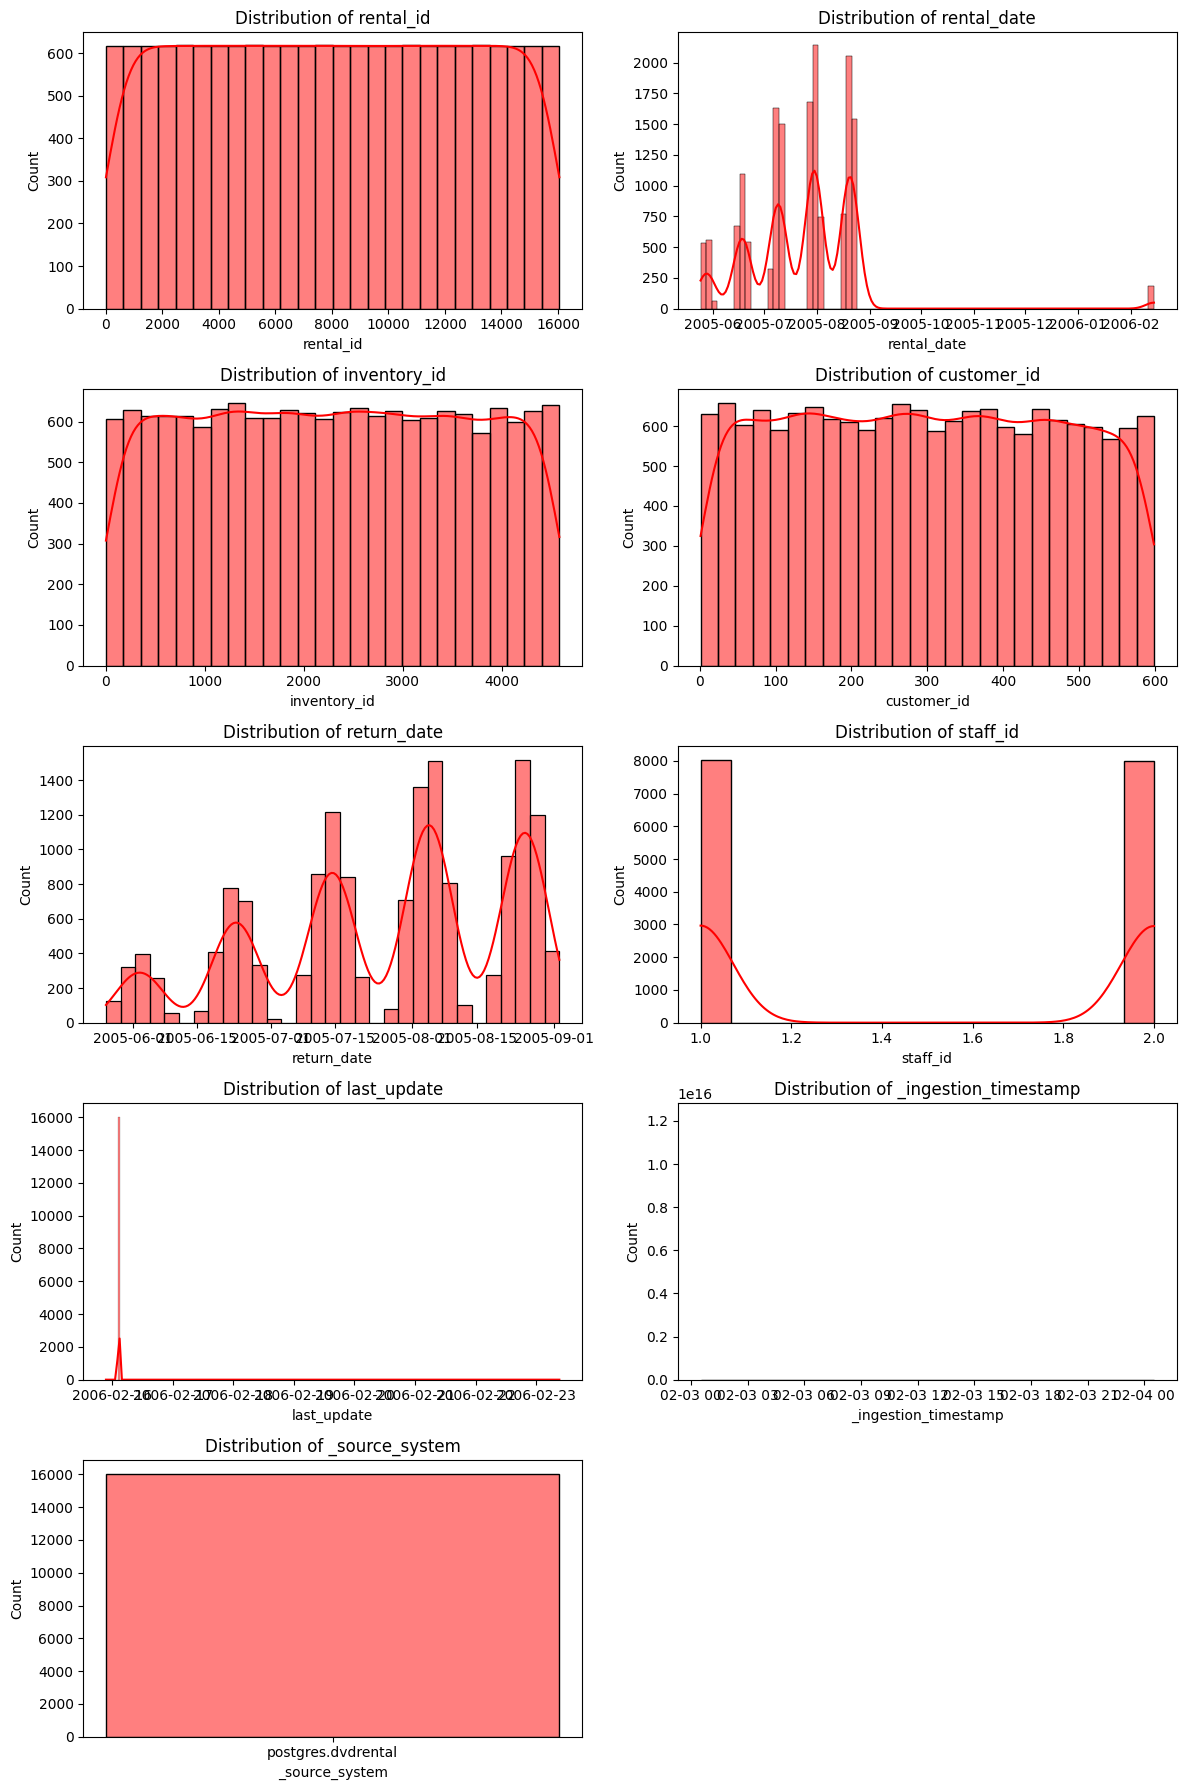

In [172]:
# visualazation of feature distributins

numeric_features = fact.columns

plt.figure(figsize=(12, 18))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(5, 2, i)
    sns.histplot(fact[col], kde=True, color='red')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


In [173]:
dim_film_cat.head()

,film_id,category_id,last_update_x,_ingestion_timestamp_x,_source_system_x,name,last_update_y,_ingestion_timestamp_y,_source_system_y,title
0,1,6,2006-02-15 10:07:09,2026-02-03 12:30:28.128806,postgres.dvdrental,Documentary,2006-02-15 09:46:27,2026-02-03 12:30:20.645744,postgres.dvdrental,Academy Dinosaur
1,2,11,2006-02-15 10:07:09,2026-02-03 12:30:28.128806,postgres.dvdrental,Horror,2006-02-15 09:46:27,2026-02-03 12:30:20.645744,postgres.dvdrental,Ace Goldfinger
2,3,6,2006-02-15 10:07:09,2026-02-03 12:30:28.128806,postgres.dvdrental,Documentary,2006-02-15 09:46:27,2026-02-03 12:30:20.645744,postgres.dvdrental,Adaptation Holes
3,4,11,2006-02-15 10:07:09,2026-02-03 12:30:28.128806,postgres.dvdrental,Horror,2006-02-15 09:46:27,2026-02-03 12:30:20.645744,postgres.dvdrental,Affair Prejudice
4,5,8,2006-02-15 10:07:09,2026-02-03 12:30:28.128806,postgres.dvdrental,Family,2006-02-15 09:46:27,2026-02-03 12:30:20.645744,postgres.dvdrental,African Egg


In [174]:
dim_film_cat.describe().T

,count,mean,min,25%,50%,75%,max,std
film_id,1000.0,500.5,1.0,250.75,500.5,750.25,1000.0,288.819436
category_id,1000.0,8.478,1.0,5.0,8.0,13.0,16.0,4.61029
last_update_x,1000,2006-02-15 10:07:08.999999616,2006-02-15 10:07:09,2006-02-15 10:07:09,2006-02-15 10:07:09,2006-02-15 10:07:09,2006-02-15 10:07:09,NaN
_ingestion_timestamp_x,1000,2026-02-03 12:30:28.128806,2026-02-03 12:30:28.128806,2026-02-03 12:30:28.128806,2026-02-03 12:30:28.128806,2026-02-03 12:30:28.128806,2026-02-03 12:30:28.128806,NaN
last_update_y,1000,2006-02-15 09:46:27.000000384,2006-02-15 09:46:27,2006-02-15 09:46:27,2006-02-15 09:46:27,2006-02-15 09:46:27,2006-02-15 09:46:27,NaN
_ingestion_timestamp_y,1000,2026-02-03 12:30:20.645744,2026-02-03 12:30:20.645744,2026-02-03 12:30:20.645744,2026-02-03 12:30:20.645744,2026-02-03 12:30:20.645744,2026-02-03 12:30:20.645744,NaN


In [176]:
dim_film_cat.shape

(1000, 10)

In [177]:
fact.shape

(16044, 9)

In [178]:
dim_film_cat.columns

Index(['film_id', 'category_id', 'last_update_x', '_ingestion_timestamp_x',
       '_source_system_x', 'name', 'last_update_y', '_ingestion_timestamp_y',
       '_source_system_y', 'title'],
      dtype='object')

In [179]:
# 2. Check for missing values
print("\nMissing values in each column:")
print(dim_film.isnull().sum())

#This data dosen't have any missing value for all variables except return_date 183


Missing values in each column:
film_id                 0
title                   0
description             0
release_year            0
language_id             0
rental_duration         0
rental_rate             0
length                  0
replacement_cost        0
rating                  0
last_update             0
special_features        0
fulltext                0
_ingestion_timestamp    0
_source_system          0
dtype: int64


In [ ]:
# visualazation of feature distributins

numeric_features = dim_film.columns

plt.figure(figsize=(12, 18))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(5, 3, i)
    sns.histplot(dim_film[col], kde=True, color='red')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


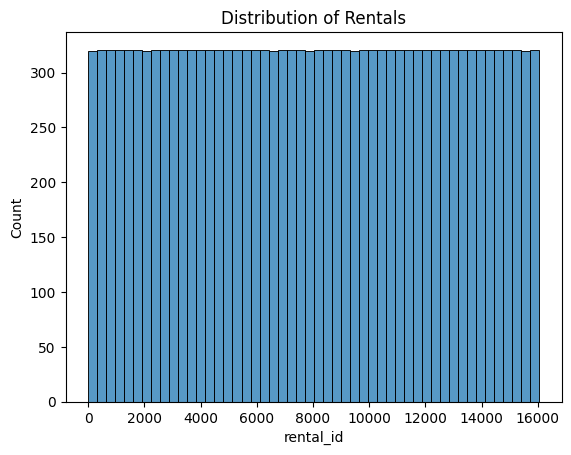

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(fact['rental_id'], bins=50)
plt.title("Distribution of Rentals")
plt.show()


In [120]:
fact['rental_date'] = pd.to_datetime(fact['rental_date'])
fact['return_date'] = pd.to_datetime(fact['return_date'])

fact['rental_duration'] = (
    fact['return_date'] - fact['rental_date']
).dt.days


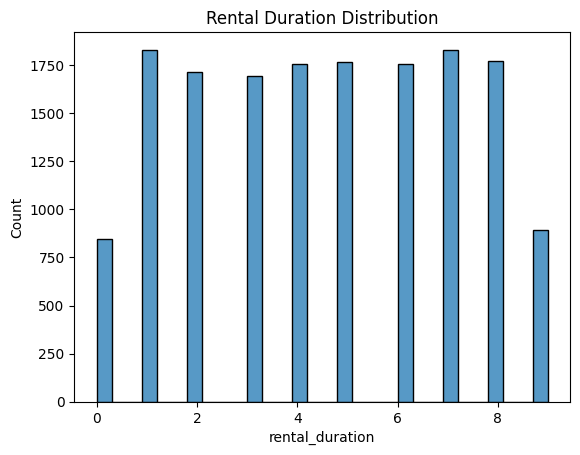

In [121]:
sns.histplot(fact['rental_duration'], bins=30)
plt.title("Rental Duration Distribution")
plt.show()


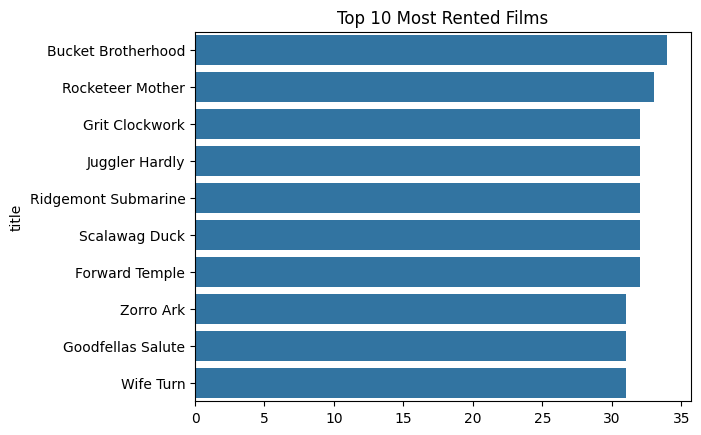

In [122]:
top_films = (
    fact['title']
    .value_counts()
    .head(10)
)

sns.barplot(
    x=top_films.values,
    y=top_films.index
)
plt.title("Top 10 Most Rented Films")
plt.show()


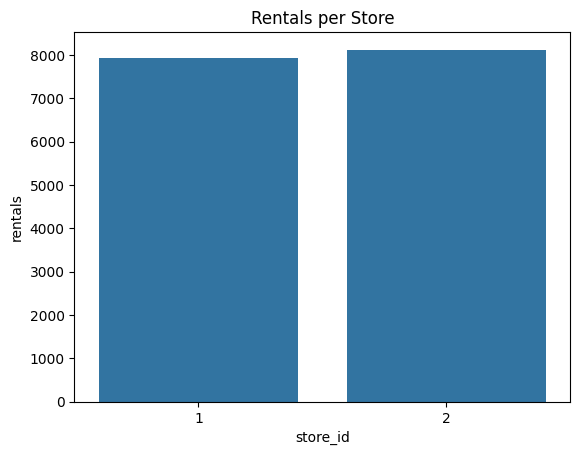

In [123]:
store_perf = (
    fact.groupby('store_id')
        .size()
        .reset_index(name='rentals')
)

sns.barplot(data=store_perf, x='store_id', y='rentals')
plt.title("Rentals per Store")
plt.show()


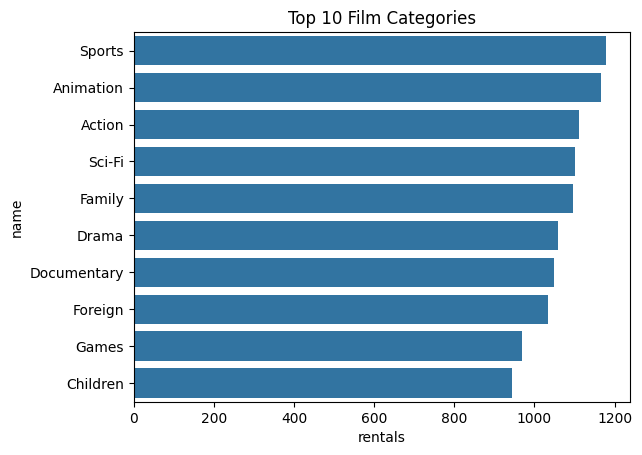

In [124]:
fact_cat = fact.merge(
    dim_film_cat[['film_id', 'name']],
    on='film_id',
    how='left'
)

cat_perf = (
    fact_cat
    .groupby('name')
        .size()
        .reset_index(name='rentals')
        .sort_values('rentals', ascending=False)
)

sns.barplot(
    data=cat_perf.head(10),
    x='rentals',
    y='name'
)
plt.title("Top 10 Film Categories")
plt.show()


In [125]:
def silver_check():
    print("Rows:", fact.shape[0])
    print("Columns:", fact.shape[1])
    print("Key columns present:",
          {'rental_date', 'film_id', 'store_id'}.issubset(fact.columns))

silver_check()


Rows: 16044
Columns: 15
Key columns present: True


In [127]:
# Fusion fact + film + catégorie
df_silver_film = fact.merge(
    dim_film[['film_id', 'title', 'rental_rate', 'replacement_cost']],
    on='film_id',
    how='left'
).merge(
    dim_film_cat[['film_id', 'name']],  # 'name' = category
    on='film_id',
    how='left'
).rename(columns={'name':'category'})


In [129]:
# Merge fact + film pour avoir rental_rate et replacement_cost
# puis merge avec film_category pour avoir la catégorie
df_silver_film = (
    fact.merge(
        dim_film[['film_id', 'title', 'rental_rate', 'replacement_cost']],
        on='film_id',
        how='left'
    )
    .merge(
        dim_film_cat[['film_id', 'name']],  # 'name' = category
        on='film_id',
        how='left'
    )
    .rename(columns={'name':'category'})
)

# Vérification
print(df_silver_film.columns)
print(df_silver_film.shape)


Index(['rental_id', 'rental_date', 'inventory_id', 'customer_id',
       'return_date', 'staff_id', 'last_update', '_ingestion_timestamp',
       '_source_system', 'film_id', 'store_id', 'title_x', 'rental_rate_x',
       'length', 'rental_duration', 'title_y', 'rental_rate_y',
       'replacement_cost', 'category'],
      dtype='object')
(16044, 19)


In [131]:
print(dim_film.columns)
print(dim_film.head(3))


Index(['film_id', 'title', 'description', 'release_year', 'language_id',
       'rental_duration', 'rental_rate', 'length', 'replacement_cost',
       'rating', 'last_update', 'special_features', 'fulltext',
       '_ingestion_timestamp', '_source_system'],
      dtype='object')
   film_id             title  \
0      133   Chamber Italian   
1      384  Grosse Wonderful   
2        8   Airport Pollock   

                                         description  release_year  \
0  A Fateful Reflection of a Moose And a Husband ...          2006   
1  A Epic Drama of a Cat And a Explorer who must ...          2006   
2  A Epic Tale of a Moose And a Girl who must Con...          2006   

   language_id  rental_duration  rental_rate  length  replacement_cost rating  \
0            1                7         4.99     117             14.99  NC-17   
1            1                5         4.99      49             19.99      R   
2            1                6         4.99      54             15

In [132]:
print(fact.columns)
print(fact.head(3))


Index(['rental_id', 'rental_date', 'inventory_id', 'customer_id',
       'return_date', 'staff_id', 'last_update', '_ingestion_timestamp',
       '_source_system', 'film_id', 'store_id', 'title', 'rental_rate',
       'length', 'rental_duration'],
      dtype='object')
   rental_id         rental_date  inventory_id  customer_id  \
0          2 2005-05-24 22:54:33          1525          459   
1          3 2005-05-24 23:03:39          1711          408   
2          4 2005-05-24 23:04:41          2452          333   

          return_date  staff_id         last_update  \
0 2005-05-28 19:40:33         1 2006-02-16 02:30:53   
1 2005-06-01 22:12:39         1 2006-02-16 02:30:53   
2 2005-06-03 01:43:41         2 2006-02-16 02:30:53   

        _ingestion_timestamp      _source_system  film_id  store_id  \
0 2026-02-03 12:30:38.491740  postgres.dvdrental      333         2   
1 2026-02-03 12:30:38.491740  postgres.dvdrental      373         2   
2 2026-02-03 12:30:38.491740  postgres.dvdr

In [135]:
fact_rental    = pd.read_parquet("s3://bronze/dvdrental/rental.parquet", filesystem=fs)
dim_inventory  = pd.read_parquet("s3://bronze/dvdrental/inventory.parquet", filesystem=fs)
dim_film       = pd.read_parquet("s3://bronze/dvdrental/film.parquet", filesystem=fs)
dim_category   = pd.read_parquet("s3://bronze/dvdrental/category.parquet", filesystem=fs)
film_category  = pd.read_parquet("s3://bronze/dvdrental/film_category.parquet", filesystem=fs)


In [136]:
# Merge fact rental avec inventory pour récupérer film_id
fact_rental = fact_rental.merge(
    dim_inventory[['inventory_id', 'film_id', 'store_id']],
    on='inventory_id',
    how='left'
)


In [137]:
def transform_to_silver(tables):
    df = tables['film_category'].merge(tables['category'], on='category_id', how='left') \
                                .merge(tables['film'], on='film_id', how='left')
    
    cols_to_keep = [
        'film_id', 'title', 'name', 'release_year', 'rental_duration', 
        'rental_rate', 'length', 'replacement_cost', 'rating', 'special_features'
    ]
    
    df_silver = df[cols_to_keep].copy()
    df_silver.rename(columns={'name': 'category'}, inplace=True)
    
    df_silver['title'] = df_silver['title'].str.title()
    df_silver['category'] = df_silver['category'].astype('category')
    
    return df_silver

tables_dict = {
    'film_category': film_category,
    'category': dim_category,
    'film': dim_film
}

df_silver_film = transform_to_silver(tables_dict)


In [138]:
df_fact_silver = fact_rental.merge(
    df_silver_film[['film_id', 'title', 'category', 'rental_rate', 'replacement_cost']],
    on='film_id',
    how='left'
)


In [139]:
df_fact_silver['rental_yield'] = (df_fact_silver['rental_rate'] / df_fact_silver['replacement_cost']) * 100


In [140]:
# Rental duration in days
df_fact_silver['rental_date'] = pd.to_datetime(df_fact_silver['rental_date'])
df_fact_silver['return_date'] = pd.to_datetime(df_fact_silver['return_date'])
df_fact_silver['actual_rental_duration'] = (df_fact_silver['return_date'] - df_fact_silver['rental_date']).dt.days

In [141]:
def silver_check(df):
    print("Rows:", df.shape[0])
    print("Columns:", df.shape[1])
    key_cols = {'rental_date', 'film_id', 'store_id', 'title', 'category'}
    print("Key columns present:", key_cols.issubset(df.columns))

silver_check(df_fact_silver)

Rows: 16044
Columns: 17
Key columns present: True


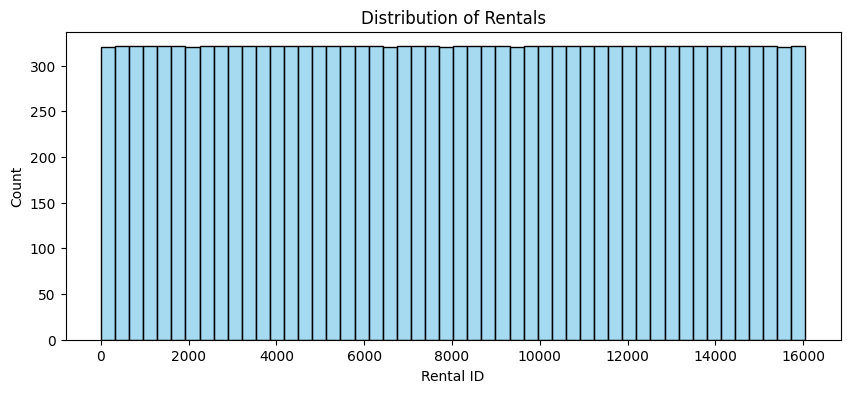

In [142]:
plt.figure(figsize=(10,4))
sns.histplot(df_fact_silver['rental_id'], bins=50, kde=False, color='skyblue')
plt.title("Distribution of Rentals")
plt.xlabel("Rental ID")
plt.ylabel("Count")
plt.show()

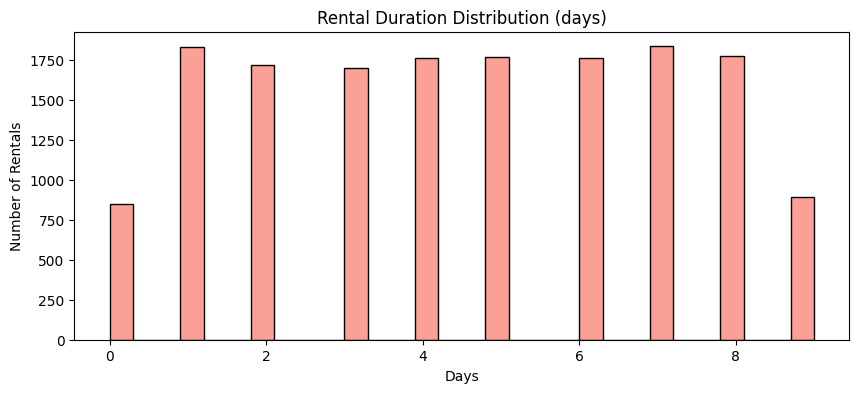

In [143]:
# 2️⃣ Rental duration distribution
plt.figure(figsize=(10,4))
sns.histplot(df_fact_silver['actual_rental_duration'], bins=30, kde=False, color='salmon')
plt.title("Rental Duration Distribution (days)")
plt.xlabel("Days")
plt.ylabel("Number of Rentals")
plt.show()

C:\Users\Meschac\AppData\Local\Temp\ipykernel_12944\4011441337.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_films.values, y=top_films.index, palette='viridis')


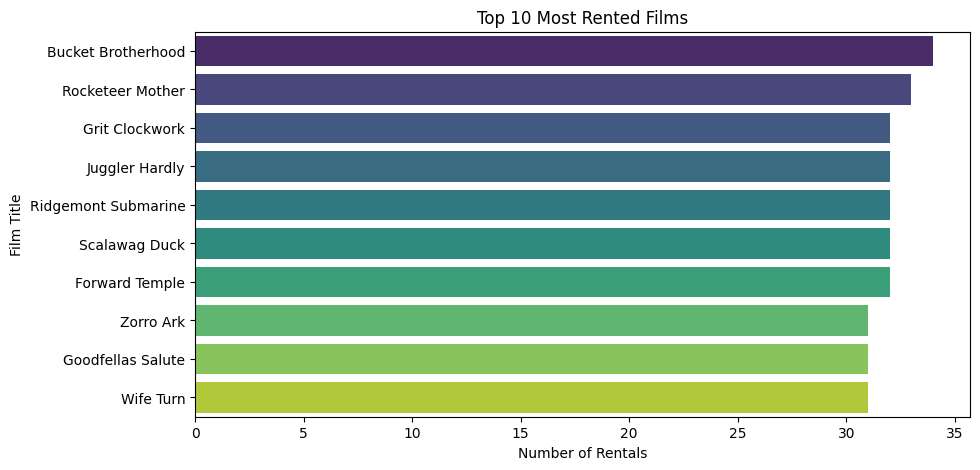

In [144]:
top_films = df_fact_silver['title'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_films.values, y=top_films.index, palette='viridis')
plt.title("Top 10 Most Rented Films")
plt.xlabel("Number of Rentals")
plt.ylabel("Film Title")
plt.show()

C:\Users\Meschac\AppData\Local\Temp\ipykernel_12944\1104145335.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=store_perf, x='store_id', y='rentals', palette='coolwarm')


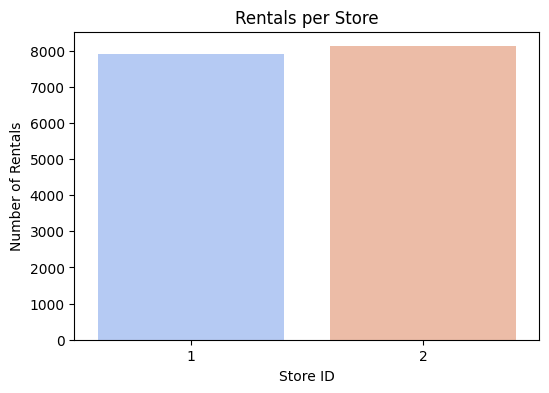

In [145]:
# 4️⃣ Rentals per store
store_perf = df_fact_silver.groupby('store_id').size().reset_index(name='rentals')
plt.figure(figsize=(6,4))
sns.barplot(data=store_perf, x='store_id', y='rentals', palette='coolwarm')
plt.title("Rentals per Store")
plt.xlabel("Store ID")
plt.ylabel("Number of Rentals")
plt.show()

C:\Users\Meschac\AppData\Local\Temp\ipykernel_12944\228701308.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cat_perf = df_fact_silver.groupby('category').size().reset_index(name='rentals') \
C:\Users\Meschac\AppData\Local\Temp\ipykernel_12944\228701308.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_perf.head(10), x='rentals', y='category', palette='magma')


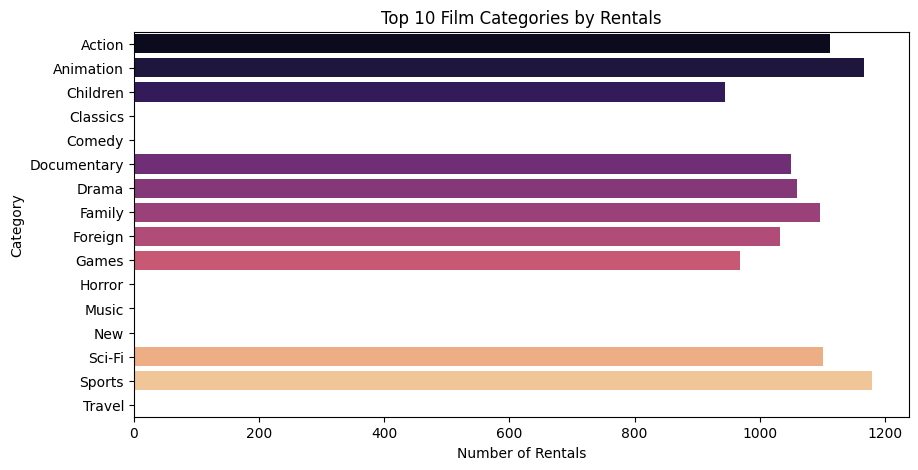

In [146]:
# 5️⃣ Top 10 film categories by rentals
cat_perf = df_fact_silver.groupby('category').size().reset_index(name='rentals') \
            .sort_values('rentals', ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(data=cat_perf.head(10), x='rentals', y='category', palette='magma')
plt.title("Top 10 Film Categories by Rentals")
plt.xlabel("Number of Rentals")
plt.ylabel("Category")
plt.show()

C:\Users\Meschac\AppData\Local\Temp\ipykernel_12944\2841317712.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


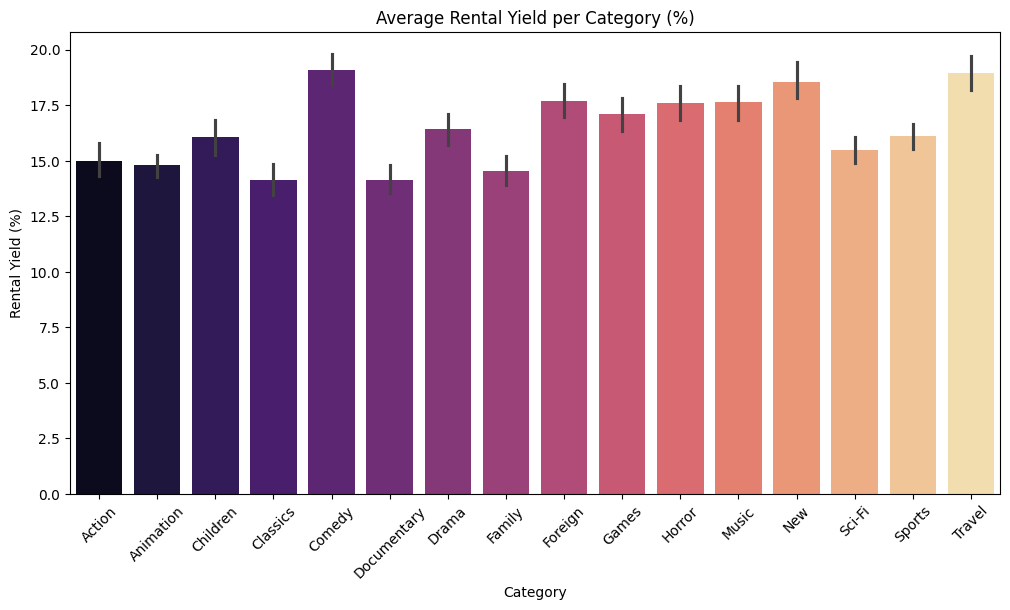

In [147]:
# 6️⃣ Average rental yield per category
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_fact_silver,
    x='category',
    y='rental_yield',
    estimator='mean',
    palette='magma'
)
plt.title("Average Rental Yield per Category (%)")
plt.xticks(rotation=45)
plt.ylabel("Rental Yield (%)")
plt.xlabel("Category")
plt.show()

C:\Users\Meschac\AppData\Local\Temp\ipykernel_12944\1328638851.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='profitability_index', y='title', data=top_profit, palette='cool')


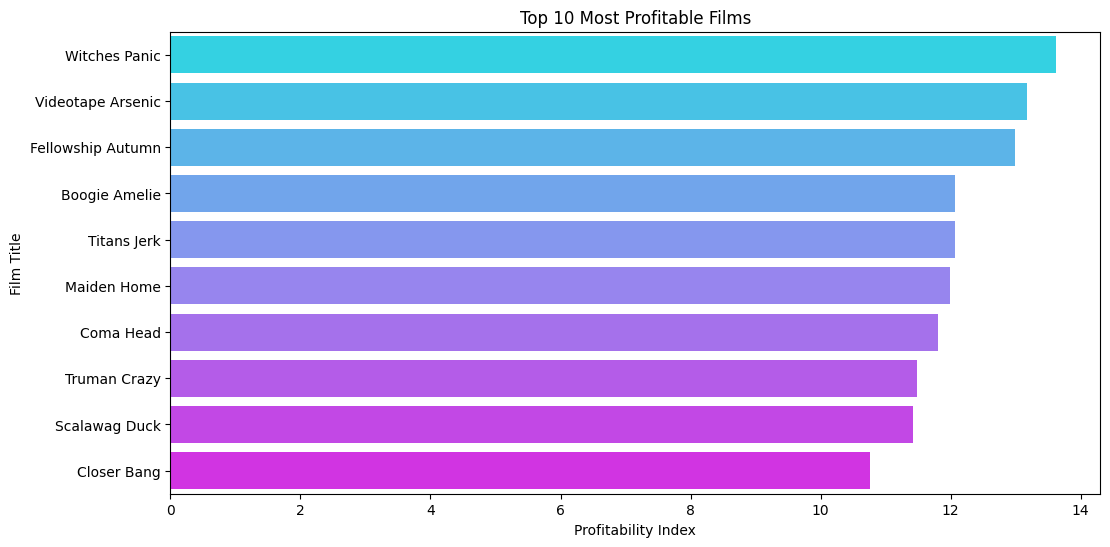

In [149]:
profit_df = df_fact_silver.groupby('title').agg(
    rentals=('rental_id','count'),
    rental_rate=('rental_rate','mean'),
    replacement_cost=('replacement_cost','mean')
).reset_index()

profit_df['profitability_index'] = profit_df['rentals'] * profit_df['rental_rate'] / profit_df['replacement_cost']
top_profit = profit_df.sort_values('profitability_index', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x='profitability_index', y='title', data=top_profit, palette='cool')
plt.title("Top 10 Most Profitable Films")
plt.xlabel("Profitability Index")
plt.ylabel("Film Title")
plt.show()


C:\Users\Meschac\AppData\Local\Temp\ipykernel_12944\1024083158.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category', y='actual_rental_duration', data=df_fact_silver, palette='Set2')


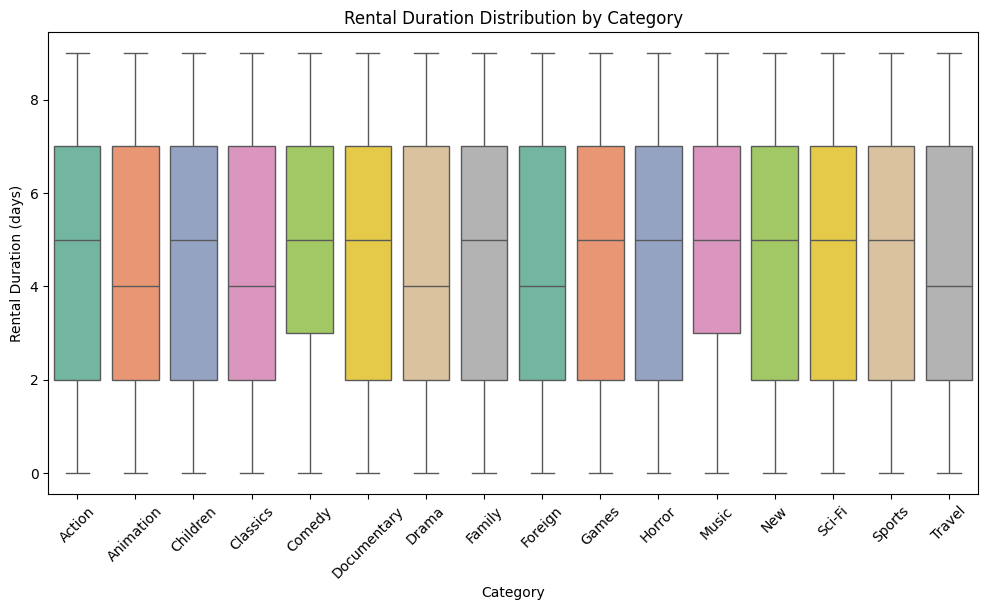

In [150]:
plt.figure(figsize=(12,6))
sns.boxplot(x='category', y='actual_rental_duration', data=df_fact_silver, palette='Set2')
plt.title("Rental Duration Distribution by Category")
plt.xticks(rotation=45)
plt.ylabel("Rental Duration (days)")
plt.xlabel("Category")
plt.show()


In [151]:
def silver_check(df):
    print("Rows:", df.shape[0])
    print("Columns:", df.shape[1])
    key_cols = {'rental_date', 'film_id', 'store_id', 'title', 'category'}
    print("Key columns present:", key_cols.issubset(df.columns))

silver_check(df_fact_silver)


Rows: 16044
Columns: 17
Key columns present: True


In [152]:
df_fact_silver['actual_rental_duration'] = (df_fact_silver['return_date'] - df_fact_silver['rental_date']).dt.days
df_fact_silver['rental_yield'] = df_fact_silver['rental_rate'] / df_fact_silver['replacement_cost'] * 100
